In [155]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [156]:
%autoreload 2

In [157]:
import re
import itertools
import pandas as pd
from uuid import uuid4
from ftfy import fix_text
from nameparser import HumanName

In [158]:
from book_tools.clean import (
    Cleaner, FillNA, Exclude, Substitute,
    FTFYFixText, RemoveNonAscii, FixMultipleSpaces,
    PadPunctuation, ParseHumanName, Lower, RemovePunctuation,
    FixedListLength, Split, ListFlatten, SplitCombinedNames
)

In [159]:
pd.set_option('display.max_colwidth', None)

In [160]:
recs = pd.read_csv('recommendations-20200829T205519.csv')
recs['uuid'] = [f"bot:{uuid4()}" for _ in range(0, len(recs))]
recs.to_csv('00_recommendations.csv', index=False)

In [161]:
recs = recs[['uuid', 'book', 'author']]
recs.head()

,uuid,book,author
0,bot:bb8d12f3-2bd1-40a0-a032-a75995390c01,The Gift of Fear,Gavin de Becker
1,bot:15bd457f-c481-4769-82bc-83c3fb8d1b4d,Getting the Love You Want,Harville Hendrix
2,bot:a5cf7af4-9231-42ac-b484-e42f47c72ca9,Codependent No More,Melody Beattie
3,bot:8b260b0a-afab-49b1-8625-4404507a838a,Spark,John J. Ratey MD
4,bot:e0c01a1a-94b0-4927-bb59-1d909b321420,The Surrender Experiment,Michael A. Singer


In [162]:
# Initialise cleaner
cleaner = Cleaner()

In [163]:
# Fill Missing Data
recs[recs['author'].isnull()]

,uuid,book,author
297,bot:6fc444c7-7f21-4927-9647-9ddf4f7469fd,Holy Bible,NaN
811,bot:6a8fba0a-1867-4dde-9aaa-667a939c53a0,Holy Bible,NaN
812,bot:052d0e0c-9e37-48e0-90db-2fc82b697f5a,The Qur'an,NaN
1367,bot:0cc243ee-d0a6-4383-aa76-35a4b0a5544a,Whole Earth Field Guide,NaN
2099,bot:6ca89b0f-f056-473f-a116-73490ad1d9d3,The Qur'an,NaN
2459,bot:9e148bea-119f-4a2a-a1d8-a2c250dcb7e2,The Qur'an,NaN


In [164]:
print(len(recs))
recs.head()

2797


,uuid,book,author
0,bot:bb8d12f3-2bd1-40a0-a032-a75995390c01,The Gift of Fear,Gavin de Becker
1,bot:15bd457f-c481-4769-82bc-83c3fb8d1b4d,Getting the Love You Want,Harville Hendrix
2,bot:a5cf7af4-9231-42ac-b484-e42f47c72ca9,Codependent No More,Melody Beattie
3,bot:8b260b0a-afab-49b1-8625-4404507a838a,Spark,John J. Ratey MD
4,bot:e0c01a1a-94b0-4927-bb59-1d909b321420,The Surrender Experiment,Michael A. Singer


In [165]:
cleaner.add(FillNA('author', value='Unknown'))

In [166]:
# Split out Non-human Authors & Unknowns
clex = pd.read_csv('clerical_exclusions__author.csv', index_col=0)
exclusions = clex['orig'].tolist()
exclusions

['Intelligent Change',
 'The American Challenge',
 'The Beatles',
 'The New Yorker',
 "Boston Women's Health Book Collective",
 'Multiple',
 'Others',
 "Old Farmer's Almanac",
 'New Games Foundation',
 'ACA WSO INC.',
 'others',
 'Anonymous',
 'Archie Superstars',
 'Axios Institute',
 'Unknown']

In [167]:
cleaner.add(Exclude('author', exclusions=exclusions))

In [168]:
# Apply Clerical Fixes to 'author' column.
clf = pd.read_csv('clerical_fixes__author.csv')
clf_map = {row['orig']: row['fix'] for _, row in clf.iterrows()}

cleaner.add(Substitute('author', subs=clf_map))

In [169]:
# Apply general text fixes
for column in ['author', 'book']:
    cleaner.add(FTFYFixText(column))
    cleaner.add(RemoveNonAscii(column))
    cleaner.add(FixMultipleSpaces(column))

In [170]:
recs = cleaner.compute(recs)

In [171]:
len(recs)

2771

In [172]:
# Split Multiple Authors
recs[recs['author'].str.contains('&| and |,')].head()

,uuid,book,author
6,bot:9d9f56f8-bf88-4bca-b8e1-5f16a6829b57,Attached: The New Science of Adult Attachment and How It Can Help YouFind - and Keep - Love,Amir Levine & Rachel Heller
17,bot:4670e13a-82fd-42fa-9fce-885bea7ec321,Aikido and the Dynamic Sphere,Adele Westbrook & Oscar Ratti
33,bot:d65b1525-6868-4847-81f5-154ff5bc38f5,The Startup Community Way,Brad Feld and Ian Hathaway
123,bot:ba426a47-264c-4820-9bf6-20d69c04d7d0,Tell Me Who You Are,Winona Guo & Priya Vulchi
144,bot:0dee78af-64c2-49a8-824d-3706b5b57937,The 15 Commitments of Conscious Leadership,"Jim Dethmer, Diana Chapman, & Kaley Warner Klemp"


In [173]:
cleaner.add(SplitCombinedNames('author'))
recs = cleaner.compute(recs)
recs.head()

,uuid,book,author
0,bot:bb8d12f3-2bd1-40a0-a032-a75995390c01,The Gift of Fear,[Gavin de Becker]
1,bot:15bd457f-c481-4769-82bc-83c3fb8d1b4d,Getting the Love You Want,[Harville Hendrix]
2,bot:a5cf7af4-9231-42ac-b484-e42f47c72ca9,Codependent No More,[Melody Beattie]
3,bot:8b260b0a-afab-49b1-8625-4404507a838a,Spark,[John J. Ratey MD]
4,bot:e0c01a1a-94b0-4927-bb59-1d909b321420,The Surrender Experiment,[Michael A. Singer]


In [174]:
recs.loc[6]

uuid                                                         bot:9d9f56f8-bf88-4bca-b8e1-5f16a6829b57
book      Attached: The New Science of Adult Attachment and How It Can Help YouFind - and Keep - Love
author                                                                   [Amir Levine, Rachel Heller]
Name: 6, dtype: object

In [175]:
# Apply Clerical Fixes to split `author` column
# and ddd spaces after punctuation e.g. 'J.K. Rowling' > 'J. K. Rowling'
recs = recs.explode('author')
cleaner.add(Substitute('author', subs=clf_map))
cleaner.add(PadPunctuation('author'))
recs = cleaner.compute(recs)

In [176]:
recs = recs.groupby(['uuid', 'book']).agg(list).reset_index()
recs.head()

,uuid,book,author
0,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,[Junichiro Tanizaki]
1,bot:00823451-fa04-4ba1-9452-5df7daa16612,Oranges,[John McPhee]
2,bot:00844fa2-9a46-4c21-9cd6-4c06d42f1686,Poor Charlie's Almanack,[Charles T. Munger]
3,bot:008e53b1-6ef3-4c73-ae85-da0203562058,Awareness,[Anthony de Mello]
4,bot:00c8d9d8-f275-44c7-b3a4-7a3697eaa438,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,"[Gary Keller, Jay Papasan]"


In [177]:
recs['num_authors'] = recs['author'].apply(lambda x: len(x))
recs.sort_values(by='num_authors', ascending=False).head()

,uuid,book,author,num_authors
1461,bot:89af5820-800e-479e-8630-58eb97d44c8f,The Dirt: Confessions of the World's Most Notorious Rock Band,"[Tommy Lee, Vince Neil, Mick Mars, Nikki Sixx, Neil Strauss]",5
1357,bot:812f70d0-977f-4759-87cd-703cb42e22d6,Team of Teams: New Rules of Engagement for a Complex World,"[Stanley McChrystal, Tantum Collins, David Silverman, Chris Fussell]",4
1322,bot:7d1c0d0d-c02a-4f51-a47c-73b23135b6b8,Crucial Conversations,"[Kerry Patterson, Joseph Grenny, Al Switzler, Ron McMillan]",4
1338,bot:7f58686a-1f87-4b84-b764-143df1e336a3,Chinese Primer: Character Text,"[Ta-tuan Ch'en, Hai-tao Tang, Yih-jian Tai, Perry Link]",4
815,bot:501ccba6-48fa-4338-9f25-70046aad6c18,Crucial Conversations,"[Kerry Patterson, Joseph Grenny, Ron McMillan, Al Switzler]",4


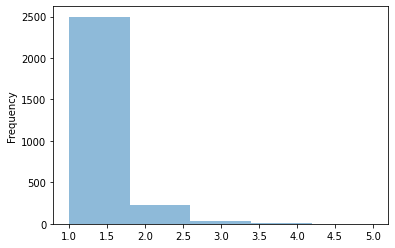

In [178]:
# How many authors should I support? 2
ax = recs['num_authors'].plot.hist(bins=5, alpha=0.5)

In [179]:
recs = recs.explode('author')
recs.head()

,uuid,book,author,num_authors
0,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,Junichiro Tanizaki,1
1,bot:00823451-fa04-4ba1-9452-5df7daa16612,Oranges,John McPhee,1
2,bot:00844fa2-9a46-4c21-9cd6-4c06d42f1686,Poor Charlie's Almanack,Charles T. Munger,1
3,bot:008e53b1-6ef3-4c73-ae85-da0203562058,Awareness,Anthony de Mello,1
4,bot:00c8d9d8-f275-44c7-b3a4-7a3697eaa438,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,Gary Keller,2


In [180]:
# Split given, middle and surnames
cleaner.add(ParseHumanName('author', out_label='split_author'))
recs = cleaner.compute(recs)
recs = recs.groupby(['uuid', 'book', 'num_authors']).agg(list).reset_index()
cleaner.add(ListFlatten('split_author'))
cleaner.add(FixedListLength('split_author', length=6, pad_value=''))
recs = cleaner.compute(recs)
recs.head()

,uuid,book,num_authors,author,split_author
0,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,1,[Junichiro Tanizaki],"[Junichiro, , Tanizaki, , , ]"
1,bot:00823451-fa04-4ba1-9452-5df7daa16612,Oranges,1,[John McPhee],"[John, , McPhee, , , ]"
2,bot:00844fa2-9a46-4c21-9cd6-4c06d42f1686,Poor Charlie's Almanack,1,[Charles T. Munger],"[Charles, T., Munger, , , ]"
3,bot:008e53b1-6ef3-4c73-ae85-da0203562058,Awareness,1,[Anthony de Mello],"[Anthony, , de Mello, , , ]"
4,bot:00c8d9d8-f275-44c7-b3a4-7a3697eaa438,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,2,"[Gary Keller, Jay Papasan]","[Gary, , Keller, Jay, , Papasan]"


In [181]:
recs['author_1_given_name'], recs['author_1_middle_name'], recs['author_1_surname'], \
recs['author_2_given_name'], recs['author_2_middle_name'], recs['author_2_surname'] = \
zip(*recs['split_author'])
recs = recs.drop(columns=['split_author'])
recs.head()

,uuid,book,num_authors,author,author_1_given_name,author_1_middle_name,author_1_surname,author_2_given_name,author_2_middle_name,author_2_surname
0,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,1,[Junichiro Tanizaki],Junichiro,,Tanizaki,,,
1,bot:00823451-fa04-4ba1-9452-5df7daa16612,Oranges,1,[John McPhee],John,,McPhee,,,
2,bot:00844fa2-9a46-4c21-9cd6-4c06d42f1686,Poor Charlie's Almanack,1,[Charles T. Munger],Charles,T.,Munger,,,
3,bot:008e53b1-6ef3-4c73-ae85-da0203562058,Awareness,1,[Anthony de Mello],Anthony,,de Mello,,,
4,bot:00c8d9d8-f275-44c7-b3a4-7a3697eaa438,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,2,"[Gary Keller, Jay Papasan]",Gary,,Keller,Jay,,Papasan


In [182]:
# Split book title and subtitle
recs[recs['book'].str.contains(':')][['book', 'author']]

,book,author
4,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,"[Gary Keller, Jay Papasan]"
6,"Humiliation: And Other Essays on Honor, Social Discomfort, and Violence",[William Ian Miller]
7,How to Live: Or A Life of Montaigne in One Question and Twenty Attempts at an Answer,[Sarah Bakewell]
15,"Zero to One: Notes on Startups, or How to Build the Future","[Peter Thiel, Blake Masters]"
18,Einstein's God: Conversations About Science and the Human Spirit,[Krista Tippett]
...,...,...
2747,Quirkology: How We Discover the Big Truths in Small Things,[Richard Wiseman]
2750,Think Twice: Harnessing the Power of Counterintuition,[Michael J. Mauboussin]
2761,The Tipping Point: How Little Things Can Make a Big Difference,[Malcolm Gladwell]
2764,"On Science, Necessity and the Love of God: Essays",[Simone Weil]


In [183]:
cleaner.add(Split('book', out_label='split_book', separator=':', maxsplit=1))
cleaner.add(FixedListLength('split_book', length=2, pad_value=''))
recs = cleaner.compute(recs)
recs['title'], recs['subtitle'] = zip(*recs['split_book'])
recs = recs.drop(columns=['split_book'])

In [184]:
match_columns = [
    'title', 'subtitle',
    'author_1_given_name', 'author_1_middle_name', 'author_1_surname',
    'author_2_given_name', 'author_2_middle_name', 'author_2_surname'
]
for column in match_columns:
    cleaner.add(Lower(column))
    cleaner.add(RemovePunctuation(column))
    cleaner.add(FixMultipleSpaces(column))

recs = cleaner.compute(recs)
recs.head()

,uuid,book,num_authors,author,author_1_given_name,author_1_middle_name,author_1_surname,author_2_given_name,author_2_middle_name,author_2_surname,title,subtitle
0,bot:0064c59e-fc4a-4255-945c-5ede8ce020e0,In Praise of Shadows,1,[Junichiro Tanizaki],junichiro,,tanizaki,,,,in praise of shadows,
1,bot:00823451-fa04-4ba1-9452-5df7daa16612,Oranges,1,[John McPhee],john,,mcphee,,,,oranges,
2,bot:00844fa2-9a46-4c21-9cd6-4c06d42f1686,Poor Charlie's Almanack,1,[Charles T. Munger],charles,t,munger,,,,poor charlies almanack,
3,bot:008e53b1-6ef3-4c73-ae85-da0203562058,Awareness,1,[Anthony de Mello],anthony,,de mello,,,,awareness,
4,bot:00c8d9d8-f275-44c7-b3a4-7a3697eaa438,The ONE Thing: The Surprisingly Simple Truth Behind Extraordinary Results,2,"[Gary Keller, Jay Papasan]",gary,,keller,jay,,papasan,the one thing,the surprisingly simple truth behind extraordinary results


In [185]:
# Write out to disk
columns = [
    'uuid', 'book', 'author', 'num_authors'
] + match_columns
recs[columns].to_csv('01_cleaned_books_of_titans.csv', index=False)